In [1]:
import numpy as np

import mapache

import matplotlib.pylab as plt
%matplotlib inline

# Managing Parties
A party is created from its name(s) and the party logo, that will be used to represent the party

Name: Ciudadanos
Full name: Ciudadanos - Partido de la Ciudadanía
Short name: C's




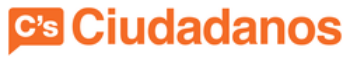

In [2]:
ciudadanos = mapache.Party('Ciudadanos',
                   logo_url = 'https://www.ciudadanos-cs.org/var/public/sections/page-imagen-del-partido/logo-ciudadanos.jpg',
                   short_name = 'C\'s',
                   full_name = 'Ciudadanos - Partido de la Ciudadanía')

ciudadanos.show()

### Getting party information from wikipedia
The wiki page of the party can be used to extract the information:

Name: Ciudadanos
Full name: Ciudadanos
Short name: C's


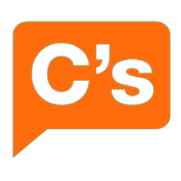

In [5]:
ciudadanos = mapache.parseutils.party_from_wiki('https://en.wikipedia.org/wiki/Citizens_(Spanish_political_party)')
ciudadanos.show()

We recover the tables with all the polls for the 2016 Spanish National elections containing the parties taking part

In [6]:
wiki_url = "https://en.wikipedia.org/wiki/Opinion_polling_for_the_Spanish_general_election,_2016"
tables = mapache.parseutils.tables_from_wiki(wiki_url)

print('{0} tables found'.format(len(tables)))

9 tables found


The first row of the table is parsed to get the name and parties. Party logos are extracted from their wikipedia pages.

This function should be easy to adapt to any other table containing a list of parties

In [7]:
def parties_from_wikitable(table):
    
    # A PartySet contains a group of parties 
    spanish_parties = mapache.PartySet()
    
    # In the the opinion polls tables the first row corresponds to the parties,
    # each cell except the first two and the last three correspond to a party
    row = mapache.parseutils.wikitable_get_rows(table)[0]
    cells = mapache.parseutils.wikitable_get_cells(row)
    
    for c in cells[2:-3]:
        
        # From each cell we recover:
        #    - The url of the party
        #    - The name of the party  (in the url name)
        #    - The small logo of the party                
        url, name = mapache.parseutils.wikitable_get_url(c)
        small_logo = mapache.parseutils.wikitable_get_imgurl(c)
           
        # The party wiki page is fetched to get the full name and full logo
        party = mapache.parseutils.party_from_wiki(url, name)
        party.set_small_logo(small_logo)
        
        spanish_parties.add(party)
        
    return spanish_parties


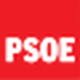
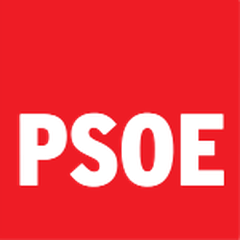
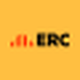
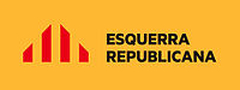
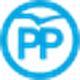
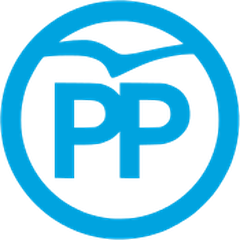
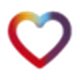
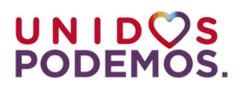
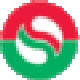
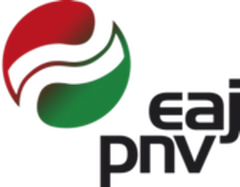
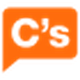
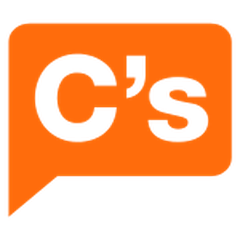
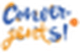
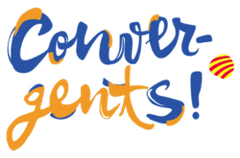

In [8]:
spanish_parties = parties_from_wikitable(tables[0])

spanish_parties.show_parties()


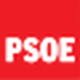
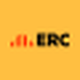
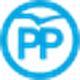
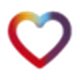
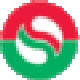
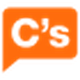
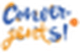

In [9]:
spanish_parties.show_parties(small=True)

The second table includes older opinion polls where the coalition 'Unidos Podemos' is not together, we can add the parties of the coalition so they are recognized in all polls


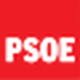
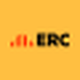
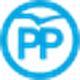
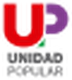
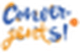
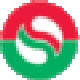
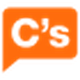
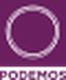

{"C'S": <mapache.core.Party at 0x7f32577724e0>,
 'CDC': <mapache.core.Party at 0x7f325d731e48>,
 'ERC': <mapache.core.Party at 0x7f325d46a4a8>,
 'IU–UPEC': <mapache.core.Party at 0x7f325779cba8>,
 'PNV': <mapache.core.Party at 0x7f325d60ab38>,
 'POD': <mapache.core.Party at 0x7f325d5d0dd8>,
 'PP': <mapache.core.Party at 0x7f325d5ec908>,
 'PSOE': <mapache.core.Party at 0x7f325d1e05c0>}

In [10]:
spanish_parties_old = parties_from_wikitable(tables[1])
spanish_parties_old.show_parties(small=True)

spanish_parties_old.parties

In [11]:
coalition_party_names = ['POD', 'IU-UPEC']

In [12]:
for p in coalition_party_names:
    spanish_parties['UP'].add_to_coalition(spanish_parties_old[p])

../mapache/core.py:226: UserWarning: Party was not found, returning closest match
  warnings.warn('Party was not found, returning closest match')


Name: Unidos Podemos
Full name: Unidos Podemos
Short name: UP
In this coalition:  ['Podemos+allies', 'IU-UPeC']


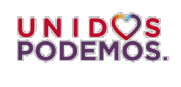

In [13]:
spanish_parties['UP'].show()

# Managing polls

We create a fake poll:

In [14]:
from dateutil.parser import parse as dateparser

In [15]:
votes = np.random.random(len(spanish_parties.parties))
votes /= sum(votes)
votes *= 100

In [16]:
pollster = 'FakePollster'
date = dateparser('18 November 2015')
party_votes = {}
for party, vote in zip(spanish_parties.parties, votes):
    party_votes[party] = vote

In [17]:
poll = mapache.Poll(parties=party_votes, date=date, pollster='Fake poll')

In [18]:
poll.print()

Pollster: Fake poll
Date: 2015-11-18 00:00:00
--------------------
PSOE: 3.81%
ERC: 13.80%
PP: 8.48%
UP: 28.35%
PNV: 9.84%
C'S: 18.68%
CDC: 17.04%


## Parsing polls
We parse the Wikipedia page to extract each poll and create a _PollsList_ of _Polls_

In [19]:
polls = mapache.parseutils.poll_from_table(tables[0], date_column=1, party_columns=(2,-3), poll_rows=(2,-1), name="Opinion Polls",
                        error_column=-3, pollster_column=0,)


print('{0} polls loaded'.format(len(polls.polls)))

36 polls loaded


In [20]:
polls.polls[4].print()

Pollster: Jaime Miquel & Asociados
Date: 2016-06-01 00:00:00
--------------------
Unidos Podemos: 24.10%
PSOE: 21.70%
ERC: 2.30%
PP: 28.70%
CDC: 2.50%
PNV: 1.30%
C's: 14.80%


We add the old polls as well (from a different table):

In [21]:
old_polls = mapache.parseutils.poll_from_table(tables[1], date_column=1, party_columns=(2,-3), poll_rows=(2,-1), name="Opinion Polls",
                        error_column=-3, pollster_column=0,)

print('{0} polls loaded'.format(len(old_polls.polls)))

polls.add(old_polls)

76 polls loaded


## Matching polls to parties

As it is likely that the all polls will not have the same name for a party, *mapache* can match a name to the closest party

In [22]:
name = 'ciutadans'
matched = spanish_parties.match(name)

print('\'{0}\' matched to \'{0}\', which included the names: {2}'.format(name, matched.name,
                                                                        matched.get_all_names()))

'ciutadans' matched to 'ciutadans', which included the names: ['Ciudadanos', "C's", "C's"]


Using name matching it is possible to get all poll results of a party

In [23]:
spanish_parties.match('unidad popular')


In [24]:
old_polls.polls[1].print()

Pollster: Celeste-Tel[CV]
Date: 2016-05-06 00:00:00
Error: 3.1%  
--------------------
C's: 15.20%
IU-UPeC: 5.20%
PSOE: 21.70%
PP: 28.80%
Podemos+allies: 19.70%


After matching the polls it is possible to plot them. The color corresponding to each party it automatically generated from the logo

*TODO*: Solve clashes between parties with similar colours

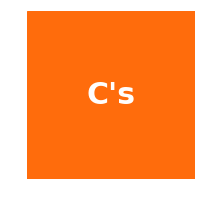

In [25]:
ciudadanos.show_color()

Simple plots can be easily created with the usual matplotlib functions. Note that the match function does not require an specific name for the party

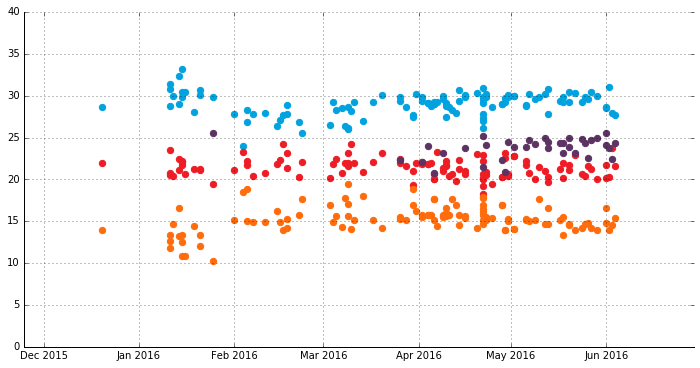

In [26]:
plt.rcParams['figure.figsize'] = (12, 6)
fig, ax = plt.subplots()

parties = ['pp', 'psoe', 'up', 'cs']

for k in parties:
    party_polls = polls.get_party(spanish_parties.match(k), join_coalitions=False)    
    dates = [x[0] for x in party_polls]
    votes = [x[1] for x in party_polls]           
    
    plt.scatter(dates, votes, color=spanish_parties.match(k).color, s=40)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.grid()
plt.ylim((0,40));


If __join_coallitions=False__, the votes of the parties being part of a coallition are not sum together, to get them we can set it to true.

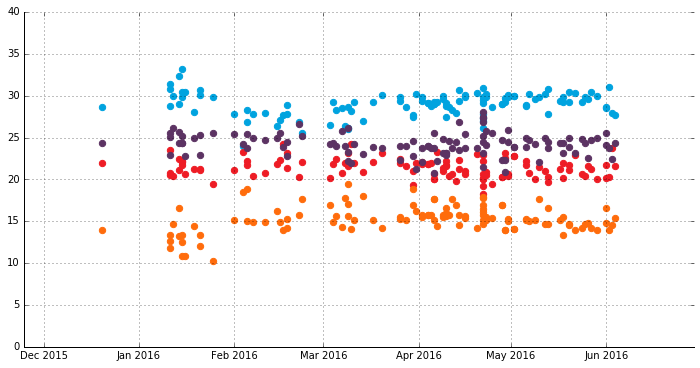

In [27]:
plt.rcParams['figure.figsize'] = (12, 6)
fig, ax = plt.subplots()

parties = ['pp', 'psoe', 'up', 'cs']

for k in parties:
    party_polls = polls.get_party(spanish_parties.match(k), join_coalitions=True)    
    dates = [x[0] for x in party_polls]
    votes = [x[1] for x in party_polls]           
    
    plt.scatter(dates, votes, color=spanish_parties.match(k).color, s=40)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.grid()
plt.ylim((0,40));


# Mapache visualization tools

We will only visualize the four main parties, to extract them from the PartyList

__TODO__: *Automatically select the top N parties* 

In [28]:
main_parties = spanish_parties.extract(['PP', 'PSOE', 'Unidos Podemos', 'Cs'])


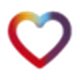
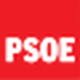
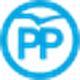
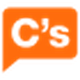

In [29]:
main_parties.show_parties(small=True)

## Visualizing a poll

In [30]:
poll=polls.polls[4]

In [31]:
elections = polls.polls[-1]

#### Bar plot
A simple plot of the parties selected (sorted by votes)

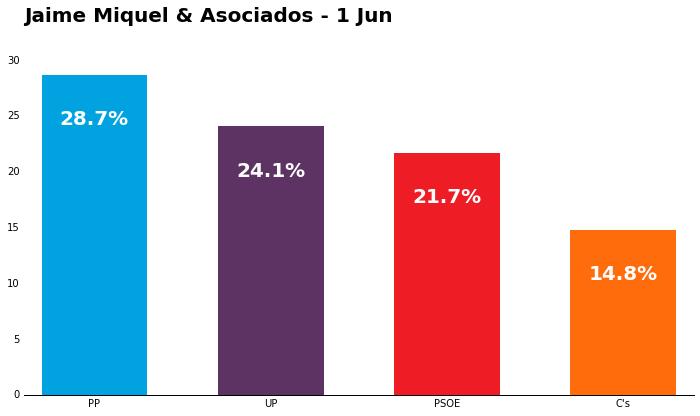

In [32]:
mapache.vis.SingleBars(poll, main_parties);

An indication of the result in a different Poll (eg. the elections) can be easily added:

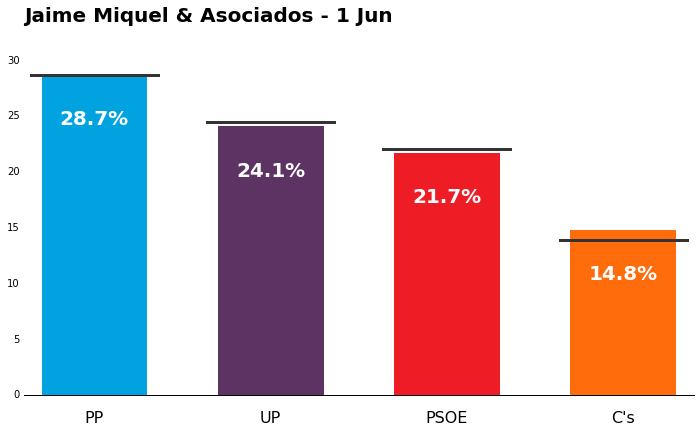

In [33]:
mapache.vis.SingleBars(poll, main_parties, elections=elections);

#Add label to the line!

## Visualizing several polls

#### Time series 
A more complex visualization including many polls. 
In this case we will load the polls previous to the last election.

In [33]:
wiki_2015 = "https://en.wikipedia.org/wiki/Opinion_polling_for_the_Spanish_general_election,_2015"
tables_2015 = mapache.parseutils.tables_from_wiki(wiki_2015) 

parties_2015 = parties_from_wikitable(tables_2015[0])
polls_2015 = mapache.parseutils.poll_from_table(tables_2015[0], date_column=1, party_columns=(2,-3), poll_rows=(2,-1), name="Opinion Polls",
                        error_column=-3, pollster_column=0,)
polls_2015._name = 'Opinion Polls'



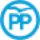
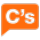
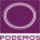
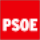

In [34]:
parties_2015 = parties_2015.extract(['PP', 'PSOE', 'Podemos', 'Cs'])
parties_2015.show_parties(small=True)

In [35]:
# The last row corresponds to the election results!

elections = polls_2015.polls[0]

elections20D = mapache.PollsList()
elections20D.add(elections)
elections20D._name = 'Elections 20D'

del polls_2015.polls[0]

In [36]:
ts = mapache.vis.TimeSeries(parties_2015)

In [37]:
# A column with all the polls (add gps to arg)
ts.add_column(polls_2015)

# A column with the election results
ts.add_column(elections20D)

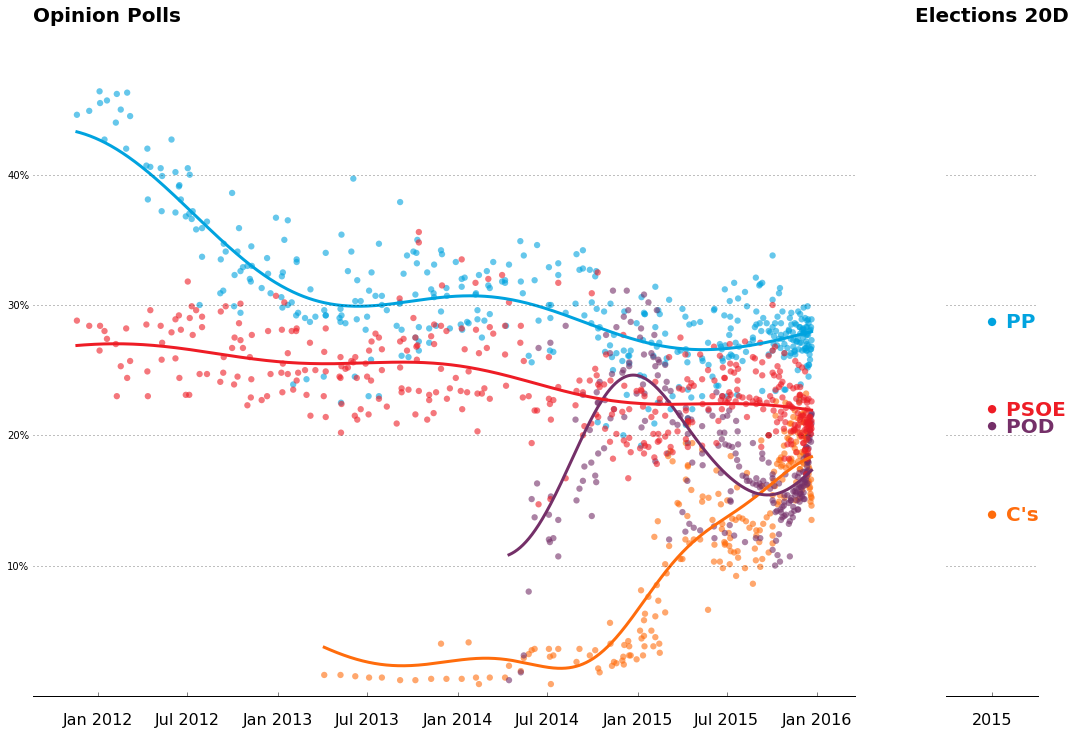

In [38]:
ts.show()